In [1]:
from jax.scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import optax
from PIL import Image
import jax.numpy as jnp
import jax
from drawingwithgaussians.rendering2d import rasterize, pixel_loss, split_gaussian

seed = 1
key = jax.random.key(seed)

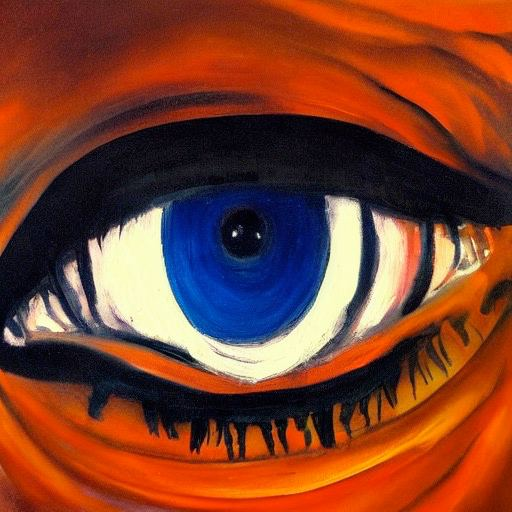

In [7]:
path = '/Users/gleb/Downloads/eye.jpeg'
img = Image.open(path)
img.resize((512, 512))

In [8]:
height = 128
width = 128
angle = 0.
num_gaussians = 1
lr = 1e-2
max_steps = 2000
learning_rate_schedule = optax.constant_schedule(lr) #cosine_onecycle_schedule(max_steps, lr)

target_image = jnp.array(img.resize((height, width)), dtype=jnp.float32)[:, :, :3] / 255
background_color = target_image.mean(0).mean(0)[None, None, :]
means = jax.random.uniform(key, (num_gaussians, 2), minval=0, maxval=height, dtype=jnp.float32)
sigmas = jax.random.uniform(key, (num_gaussians, 2), minval=5, maxval=20, dtype=jnp.float32)
covariances = jnp.stack([jnp.diag(sigma**2) for sigma in sigmas])
L = jax.lax.linalg.cholesky(covariances)
colors = jax.random.uniform(key, (num_gaussians, 4), jnp.float32, 0, 1)
colors = colors.at[:, 3].set(colors[:, 3] / colors[:, 3].sum())
r = R.from_euler('x', [angle,])
rotmats = jnp.repeat(r.as_matrix()[1:, 1:][None], num_gaussians, axis=0)

optimize_means = optax.adam(learning_rate_schedule)
optimize_cov = optax.adam(learning_rate_schedule)
optimize_colors = optax.adam(learning_rate_schedule)
optimize_rotmats = optax.adam(learning_rate_schedule)
optimize_background = optax.adam(learning_rate_schedule)

opt_state_means = optimize_means.init(means)
opt_state_cov = optimize_cov.init(L)
opt_state_colors = optimize_colors.init(colors)
opt_state_rotmats = optimize_rotmats.init(rotmats)
opt_state_background = optimize_background.init(background_color)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


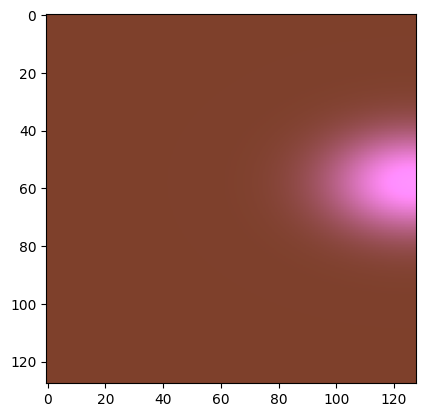

In [9]:
background = jnp.repeat(jnp.repeat(background_color, height, axis=0), width, axis=1)
renderred_gaussians, opacity, partitioning = rasterize(means, covariances, colors, rotmats, background, height, width)
plt.imshow(renderred_gaussians)

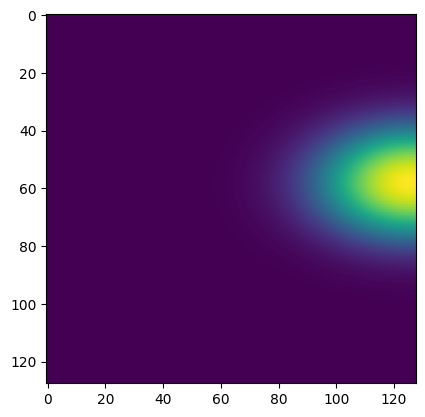

In [10]:
plt.imshow(opacity)

In [11]:
prev_stats = []
frames = []
for num_epoch in range(10):
    for step in range(max_steps):
        (loss, renderred_gaussians), gradients = jax.value_and_grad(pixel_loss, argnums=[0, 1, 2, 3, 4], has_aux=True)(means, L, colors, rotmats, background_color, target_image)
        
        frames.append(renderred_gaussians)

        updates_means, opt_state_means = optimize_means.update(gradients[0], opt_state_means)
        means = optax.apply_updates(means, updates_means)

        updates_cov, opt_state_cov = optimize_cov.update(gradients[1], opt_state_cov)
        L = optax.apply_updates(L, updates_cov)

        updates_colors, opt_state_colors = optimize_colors.update(gradients[2], opt_state_colors)
        colors = optax.apply_updates(colors, updates_colors)

        updates_rotmats, opt_state_rotmats = optimize_rotmats.update(gradients[3], opt_state_rotmats)
        rotmats = optax.apply_updates(rotmats, updates_rotmats)

        updates_background, opt_state_background = optimize_background.update(gradients[4], opt_state_background)
        background_color = optax.apply_updates(background_color, updates_background)

        if jnp.isnan(loss):
            print(prev_stats)
            print(loss, [(jnp.linalg.norm(gradient), gradient.max()) for gradient in gradients])
            break
        if step % 50 == 0:
            print(loss, step, num_epoch, means.shape[0])
        prev_stats = [(jnp.linalg.norm(gradient), gradient.max()) for gradient in gradients]

    smeans = []
    scovs = []
    scolors = []
    srotmats = []
    covariances = L.at[:, 0, 1].set(0) @ jnp.transpose(
        L.at[:, 0, 1].set(0), axes=[0, 2, 1]
    )
    for mean, cov, color, rotmat in zip(means, covariances, colors, rotmats):
        mean, cov, color, rotmat = split_gaussian(mean, cov, color, rotmat)
        smeans.append(mean.reshape(2, -1))
        scovs.append(cov.reshape(2, 2, 2))
        scolors.append(color.reshape(2, -1))
        srotmats.append(rotmat.reshape(2, 2, 2))

    means, covariances, colors, rotmats = jnp.concatenate(smeans), jnp.concatenate(scovs), jnp.concatenate(scolors), jnp.concatenate(srotmats)
    L = jax.lax.linalg.cholesky(covariances)
    
    opt_state_means = optimize_means.init(means)
    opt_state_cov = optimize_cov.init(L)
    opt_state_colors = optimize_colors.init(colors)
    opt_state_rotmats = optimize_rotmats.init(rotmats)
    opt_state_background = optimize_background.init(background_color)


0.084217906 0 0 1
0.0744743 50 0 1
0.0735157 100 0 1
0.07289672 150 0 1
0.0721589 200 0 1
0.07131539 250 0 1
0.07044746 300 0 1
0.069464095 350 0 1
0.06830871 400 0 1
0.06724378 450 0 1
0.066388436 500 0 1
0.065717295 550 0 1
0.06518793 600 0 1
0.064764746 650 0 1
0.06442112 700 0 1
0.06413776 750 0 1
0.06390081 800 0 1
0.0637 850 0 1
0.06352793 900 0 1
0.063378915 950 0 1
0.06324862 1000 0 1
0.06313376 1050 0 1
0.06303166 1100 0 1
0.062940225 1150 0 1
0.06285778 1200 0 1
0.06278291 1250 0 1
0.0627145 1300 0 1
0.06265161 1350 0 1
0.06259344 1400 0 1
0.06253927 1450 0 1
0.062488567 1500 0 1
0.062440842 1550 0 1
0.0623956 1600 0 1
0.06235256 1650 0 1
0.062311452 1700 0 1
0.06227199 1750 0 1
0.06223401 1800 0 1
0.062197395 1850 0 1
0.062162153 1900 0 1
0.06212818 1950 0 1
0.06540267 0 1 2
0.056487806 50 1 2
0.05369407 100 1 2
0.052850753 150 1 2
0.052521408 200 1 2
0.05231394 250 1 2
0.05215208 300 1 2
0.052015506 350 1 2
0.05189754 400 1 2
0.051795043 450 1 2
0.051706053 500 1 2
0.051628

In [11]:
import numpy as np
import cv2
out = cv2.VideoWriter('outpy.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 24, (width, height))
for frame in frames:
    out.write(np.array((frame[:, :, ::-1] * 255).astype(np.uint8)))
out.release()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


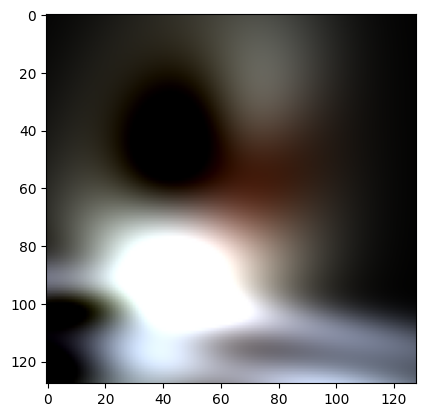

In [92]:
covariances = L@jnp.transpose(L, axes=[0, 2, 1])
background = jnp.repeat(jnp.repeat(background_color, height, axis=0), width, axis=1)
renderred_gaussians, opacity, occupancy = rasterize(means, covariances, colors, rotmats, background, height, width)
plt.imshow(renderred_gaussians)

In [85]:
means.shape

(4, 2)

Array([[ 8.086459, 12.419434],
       [ 8.086459, 12.419434],
       [11.054472,  9.892498],
       [11.054472,  9.892498],
       [ 7.106157, 13.657092],
       [ 7.106157, 13.657092]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


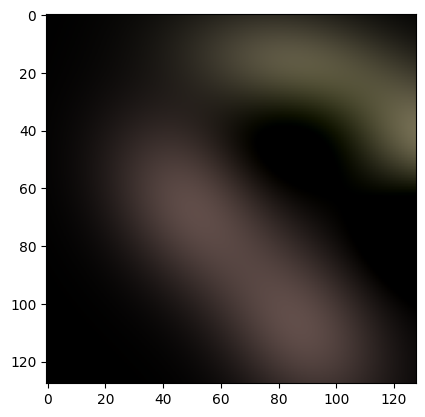

In [34]:
renderred_gaussians, opacity, occupancy = rasterize(means, covariances, colors, rotmats, background, height, width)
plt.imshow(renderred_gaussians)

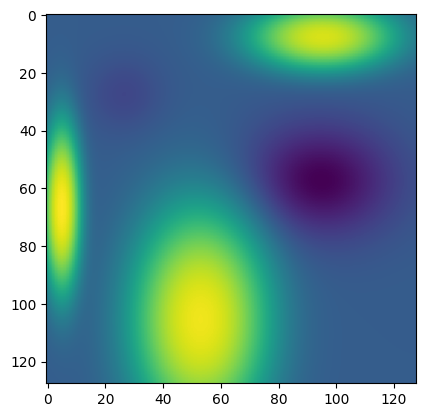

In [ ]:
plt.imshow(opacity)